In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
import os
from tqdm import tqdm

In [2]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D

In [5]:
train_df = pd.read_csv('../data/train.csv')
strs = train_df['image_id'].values
strs = [string+'_f.png' for string in strs]
train_df.drop(['image_id'],axis=1,inplace=True)
train_df['image_id'] = strs

In [6]:
#train_df = train_df.astype(str)
train_df.dtypes

grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
image_id               object
dtype: object

In [7]:
def apply_augmentation(image):
    augmentation_pipeline = A.Compose(
        [
            A.OneOf(
                [
                    # apply one of transforms to 50% of images
                    A.RandomContrast(), # apply random contrast
                    A.RandomGamma(), # apply random gamma
                    A.RandomBrightness(), # apply random brightness
                ],
                p = 0.5
            ),
            A.OneOf(
                [
                    # apply one of transforms to 50% images
                    A.ElasticTransform(alpha = 120,sigma = 120 * 0.05,alpha_affine = 120 * 0.03),
                    A.GridDistortion(),
                    A.OpticalDistortion(distort_limit = 2,shift_limit = 0.5),
                ],
                p = 0.5
            )
        ],
        p = 0.5
    )
    images_aug = augmentation_pipeline(image = image)['image']
    return images_aug

In [8]:
datadir_toy_processed_images = '/home/sayan/Documents/Bengali_Grapheme/images/toy_processed_images'
train_df_sample = pd.DataFrame()
for (directory, _ , image_names) in os.walk(datadir_toy_processed_images):
        train_df_sample = train_df[train_df['image_id'].isin(image_names)]

In [9]:
im_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                               preprocessing_function=apply_augmentation)


gen_image = im_generator.flow_from_dataframe(train_df_sample,
                                             directory='/home/sayan/Documents/Bengali_Grapheme/images/toy_processed_images',
                                             x_col='image_id',
                                             y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
                                             target_size = (64,64),
                                             class_mode = 'multi_output',
                                             color_mode = 'grayscale',
                                             batch_size = 1,
                                             shuffle=False, 
                                             seed=42)

Found 20084 validated image filenames.


---

In [14]:
input_ = Input(shape=(64,64,1))

conv1 = Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1))(input_)
avgpool1 = AvgPool2D()(conv1)

conv2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(avgpool1)
avgpool2 = AvgPool2D()(conv2)

flat = Flatten()(avgpool2)

dense_vowel_1 = Dense(800,activation='relu')(flat)
dense_vowel_2 = Dense(600,activation='relu')(dense_vowel_1)
dense_vowel_3 = Dense(100,activation='relu')(dense_vowel_2)
output_vowel = Dense(11,activation='softmax')(dense_vowel_3)

dense_consonant_1 = Dense(800,activation='relu')(flat)
dense_consonant_2 = Dense(600,activation='relu')(dense_consonant_1)
dense_consonant_3 = Dense(100,activation='relu')(dense_consonant_2)
output_consonant = Dense(11,activation='softmax')(dense_consonant_3)

dense_root_1 = Dense(2000,activation='relu')(flat)
dense_root_2 = Dense(1500,activation='relu')(dense_root_1)
dense_root_3 = Dense(1000,activation='relu')(dense_root_2)
dense_root_4 = Dense(800,activation='relu')(dense_root_3)
dense_root_5 = Dense(250,activation='relu')(dense_root_4)
output_root = Dense(168,activation='softmax')(dense_root_4)

model = keras.Model(inputs=[input_],outputs=[output_vowel,output_consonant,output_root])
model.compile(loss = keras.losses.categorical_crossentropy, 
              optimizer = 'sgd',
              metrics=['accuracy'])

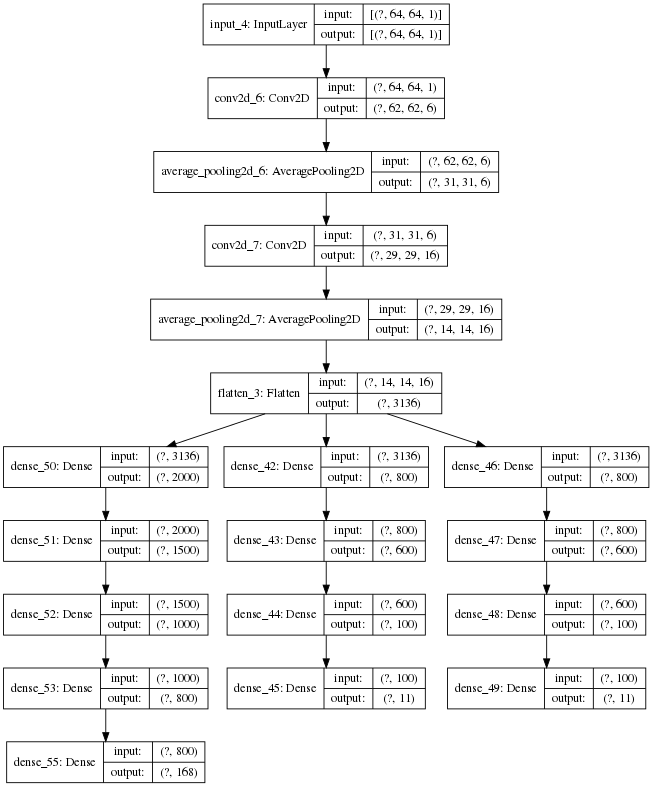

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
history = model.fit(gen_image,epochs = 10,)

Train for 20084 steps
Epoch 1/10


In [378]:
val = gen_image.next()[0][0]

In [379]:
val.shape

(64, 64, 1)